# Distance-based treatment effects for many cohorts

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

Expand on the example in the previous document.

Here we show the difference in outcome measures for nLVO, LVO, and a mixed population (49.6% nLVO, 50.4% LVO). There is 60 min travel time between IVT and MT centres.

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import copy
import os

from stroke_outcome.continuous_outcome import Continuous_outcome
from geography_plot import find_mask_within_flattened_circle
from geography_plot import circle_plot

In [2]:
import stroke_outcome

In [3]:
stroke_outcome.__version__

'0.1.6'

In [4]:
# Set up MatPlotLib
%matplotlib inline

In [5]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

## Import data

Patient proportions:

In [6]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [7]:
patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

Calculate some additional proportions:

In [8]:
# Proportion of treated LVO patients:
prop_lvo_treated = 0.0

for key, value in patient_proportions.items():
    if (('lvo' in key) & ('nlvo' not in key) & ('no_treat' not in key)):
        print(key)
        prop_lvo_treated += value

prop_lvo_treated

lvo_ivt_only
lvo_ivt_mt
lvo_mt_only


0.10840000000000001

In [9]:
# Proportion of treated ischaemic patients:
prop_ischaemic_treated = 0.0

for key, value in patient_proportions.items():
    if (('lvo' in key) & ('no_treat' not in key)):
        print(key)
        prop_ischaemic_treated += value

prop_ischaemic_treated

lvo_ivt_only
lvo_ivt_mt
lvo_mt_only
nlvo_ivt


0.21500000000000002

In [10]:
# Proportion of ischaemic patients:
prop_ischaemic = 1.0 - patient_proportions['haemorrhagic']

prop_ischaemic

0.864

In [11]:
prop_nlvo_of_treated = patient_proportions['nlvo_ivt'] / prop_ischaemic_treated
prop_lvo_of_treated = 1.0 - prop_nlvo_of_treated

prop_nlvo_of_treated, prop_lvo_of_treated

(0.49581395348837204, 0.5041860465116279)

Pathway times:

In [12]:
fixed_times = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'pathway_times.csv'),
    index_col=0, header=None).squeeze()

In [13]:
fixed_times['travel_ivt_to_mt'] = 50

In [14]:
fixed_times

0
onset_to_ambulance_arrival                  60
arrival_to_ivt                              30
arrival_to_mt                               90
net_operational_delay_to_mt_for_transfer    60
travel_ivt_to_mt                            50
Name: 1, dtype: int64

## Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

| Centre | x | y |
| --- | --- | --- |
| IVT | 0 | 0 |
| IVT/MT | 0 | $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$ |

In [15]:
ivt_coords = [0, 0]
mt_coords  = [0, -fixed_times['travel_ivt_to_mt']]

Change these parameters:

In [16]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [17]:
def make_time_grid(
        xy_max,
        step,
        x_offset=0,
        y_offset=0
    ):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [18]:
grid_time_travel_directly_to_ivt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=ivt_coords[0], 
    y_offset=ivt_coords[1]
)

In [19]:
grid_time_travel_directly_to_mt = make_time_grid(
    time_travel_max,
    grid_step,
    x_offset=mt_coords[0],
    y_offset=mt_coords[1]
)

In [20]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [21]:
extent = [
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5,
    -grid_xy_max - grid_step*0.5,
    +grid_xy_max - grid_step*0.5
]

In [22]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max
)

coords_valid = np.where(grid_mask<1)

## Define total time grids (including fixed times for delays)

Fixed times for additional delays:

In [23]:
import pandas as pd
import os

In [24]:
grid_time_ivt_at_ivtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['arrival_to_ivt']
    )

In [25]:
grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['arrival_to_ivt'] + 
    fixed_times['net_operational_delay_to_mt_for_transfer'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['arrival_to_mt']
    )

In [26]:
grid_time_ivt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['arrival_to_ivt']
    )

In [27]:
grid_time_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['arrival_to_mt']
    )

__check the assumption of time between IVT and MT at the same centre above__

### Create outcome model inputs

In [28]:
df_ivtcentre = pd.DataFrame()
df_ivtcentre['onset_to_needle_mins'] = grid_time_ivt_at_ivtcentre.flatten()
df_ivtcentre['onset_to_puncture_mins'] = grid_time_ivt_at_ivt_then_mt_at_mtcentre.flatten()

In [29]:
df_ivtmtcentre = pd.DataFrame()
df_ivtmtcentre['onset_to_needle_mins'] = grid_time_ivt_at_mtcentre.flatten()
df_ivtmtcentre['onset_to_puncture_mins'] = grid_time_ivt_then_mt_at_mtcentre.flatten()

Assign three cohorts to these treatment times:

+ nLVO + IVT
+ LVO + IVT
+ LVO + MT

In [30]:
df_ivtcentre_nlvo_ivt = df_ivtcentre.copy()
df_ivtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [31]:
df_ivtmtcentre_nlvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_nlvo_ivt['stroke_type_code'] = 1
df_ivtmtcentre_nlvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_nlvo_ivt['mt_chosen_bool'] = 0

In [32]:
df_ivtcentre_lvo_ivt = df_ivtcentre.copy()
df_ivtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [33]:
df_ivtmtcentre_lvo_ivt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_ivt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_ivt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_ivt['mt_chosen_bool'] = 0

In [34]:
df_ivtcentre_lvo_ivt_mt = df_ivtcentre.copy()
df_ivtcentre_lvo_ivt_mt['stroke_type_code'] = 2
df_ivtcentre_lvo_ivt_mt['ivt_chosen_bool'] = 1
df_ivtcentre_lvo_ivt_mt['mt_chosen_bool'] = 1

In [35]:
df_ivtmtcentre_lvo_ivt_mt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_ivt_mt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_ivt_mt['ivt_chosen_bool'] = 1
df_ivtmtcentre_lvo_ivt_mt['mt_chosen_bool'] = 1

In [36]:
df_ivtcentre_lvo_mt = df_ivtcentre.copy()
df_ivtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtcentre_lvo_mt['ivt_chosen_bool'] = 0
df_ivtcentre_lvo_mt['mt_chosen_bool'] = 1

In [37]:
df_ivtmtcentre_lvo_mt = df_ivtmtcentre.copy()
df_ivtmtcentre_lvo_mt['stroke_type_code'] = 2
df_ivtmtcentre_lvo_mt['ivt_chosen_bool'] = 0
df_ivtmtcentre_lvo_mt['mt_chosen_bool'] = 1

### Calculate outcomes

In [38]:
# Set up outcome model
outcome_model = Continuous_outcome()

In [39]:
dfs = [
    df_ivtcentre_nlvo_ivt,
    df_ivtmtcentre_nlvo_ivt,
    df_ivtcentre_lvo_ivt,
    df_ivtmtcentre_lvo_ivt,
    df_ivtcentre_lvo_ivt_mt,
    df_ivtmtcentre_lvo_ivt_mt,
    df_ivtcentre_lvo_mt,
    df_ivtmtcentre_lvo_mt,
]

for df in dfs:
    outcome_model.assign_patients_to_trial(df)
    
    # Calculate outcomes:
    patient_data_dict, outcomes_by_stroke_type, full_cohort_outcomes = (
        outcome_model.calculate_outcomes())
    
    # Make a copy of the results:
    outcomes_by_stroke_type = copy.copy(outcomes_by_stroke_type)
    full_cohort_outcomes = copy.copy(full_cohort_outcomes)
    
    # Place the relevant results into the starting dataframe:
    df['added_utility'] = full_cohort_outcomes['each_patient_utility_shift']
    df['mean_mrs'] = full_cohort_outcomes['each_patient_mrs_post_stroke']
    df['mrs_less_equal_2'] = full_cohort_outcomes['each_patient_mrs_dist_post_stroke'][:, 2]
    df['mrs_shift'] = full_cohort_outcomes['each_patient_mrs_shift']

## Combine cohorts into mixed population

Calculate outcomes for the combined cohorts:

In [40]:
outcome_cols = ['added_utility', 'mean_mrs', 'mrs_less_equal_2', 'mrs_shift']

IVT centre grid:

In [41]:
# Combine the outcomes:
df_mixed_ivtcentre = pd.DataFrame(
    np.sum((
        patient_proportions['nlvo_ivt'] * df_ivtcentre_nlvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_only'] * df_ivtcentre_lvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_mt'] * df_ivtcentre_lvo_ivt_mt[outcome_cols],
        patient_proportions['lvo_mt_only'] * df_ivtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtcentre = df_mixed_ivtcentre / prop_ischaemic_treated

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtcentre['onset_to_needle_mins'] = df_ivtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtcentre['onset_to_puncture_mins'] = df_ivtcentre_nlvo_ivt['onset_to_puncture_mins']

MT centre grid:

In [42]:
# Combine the outcomes:
df_mixed_ivtmtcentre = pd.DataFrame(
    np.sum((
        patient_proportions['nlvo_ivt'] * df_ivtmtcentre_nlvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_only'] * df_ivtmtcentre_lvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_mt'] * df_ivtmtcentre_lvo_ivt_mt[outcome_cols],
        patient_proportions['lvo_mt_only'] * df_ivtmtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_mixed_ivtmtcentre = df_mixed_ivtmtcentre / prop_ischaemic_treated

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the nLVO IVT df:
df_mixed_ivtmtcentre['onset_to_needle_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_needle_mins']
df_mixed_ivtmtcentre['onset_to_puncture_mins'] = df_ivtmtcentre_nlvo_ivt['onset_to_puncture_mins']

### Combine LVO only

IVT centre grid:

In [43]:
# Combine the outcomes:
df_lvo_ivtcentre = pd.DataFrame(
    np.sum((
        patient_proportions['lvo_ivt_only'] * df_ivtcentre_lvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_mt'] * df_ivtcentre_lvo_ivt_mt[outcome_cols],
        patient_proportions['lvo_mt_only'] * df_ivtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_lvo_ivtcentre = df_lvo_ivtcentre / prop_lvo_treated

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the LVO IVT df:
df_lvo_ivtcentre['onset_to_needle_mins'] = df_ivtcentre_lvo_ivt['onset_to_needle_mins']
df_lvo_ivtcentre['onset_to_puncture_mins'] = df_ivtcentre_lvo_ivt['onset_to_puncture_mins']

MT centre grid:

In [44]:
# Combine the outcomes:
df_lvo_ivtmtcentre = pd.DataFrame(
    np.sum((
        patient_proportions['lvo_ivt_only'] * df_ivtmtcentre_lvo_ivt[outcome_cols],
        patient_proportions['lvo_ivt_mt'] * df_ivtmtcentre_lvo_ivt_mt[outcome_cols],
        patient_proportions['lvo_mt_only'] * df_ivtmtcentre_lvo_mt[outcome_cols],
    ), axis=0),
    columns=outcome_cols
)

# Adjust outcomes for just the treated population:
df_lvo_ivtmtcentre = df_lvo_ivtmtcentre / prop_lvo_treated

# Copy over the treatment times.
# They're the same times in all three dataframes so just pick the LVO IVT df:
df_lvo_ivtmtcentre['onset_to_needle_mins'] = df_ivtmtcentre_lvo_ivt['onset_to_needle_mins']
df_lvo_ivtmtcentre['onset_to_puncture_mins'] = df_ivtmtcentre_lvo_ivt['onset_to_puncture_mins']

### Difference grids

Calculate the differences:

In [45]:
df_nlvo_ivt_diff = df_ivtmtcentre_nlvo_ivt - df_ivtcentre_nlvo_ivt
df_lvo_diff = df_lvo_ivtmtcentre - df_lvo_ivtcentre
df_lvo_ivt_diff = df_ivtmtcentre_lvo_ivt - df_ivtcentre_lvo_ivt
df_lvo_ivt_mt_diff = df_ivtmtcentre_lvo_ivt_mt - df_ivtcentre_lvo_ivt_mt
df_lvo_mt_diff = df_ivtmtcentre_lvo_mt - df_ivtcentre_lvo_mt
df_mixed_diff = df_mixed_ivtmtcentre - df_mixed_ivtcentre

## Individual circle plots

Select colour limits for the circle plot:

In [46]:
time_step_circle = 5
circ_linewidth = 0.5

In [47]:
def round_to_next(vmin, vmax, r=0.005):
    """Round vmin and vmax to nicer values"""
    vmax_r = np.ceil(np.sign(vmax) * np.abs(vmax) / r) * r
    vmin_r = np.floor(vmin / r) * r
    return vmin_r, vmax_r

In [48]:
# Find the actual minumum and maximum values in the grid:
vmin_total = np.nanmin(df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])
vmax_total = np.nanmax(df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])

vmin_util, vmax_util = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_util)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_util)

Max. value in grid: 0.03822642598219561
Chosen vmax:        0.04
Min. value in grid: 0.01243176782529233
Chosen vmin:        0.01


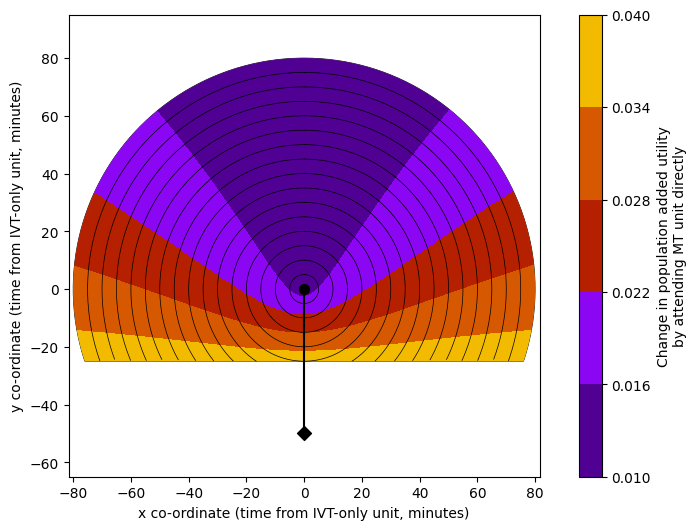

In [49]:
circle_plot(
    df_mixed_diff['added_utility'].values.reshape(grid_time_travel_directly_to_mt.shape),
    fixed_times['travel_ivt_to_mt'], 
    time_travel_max,
    time_step_circle,
    vmin_util,
    vmax_util,
    imshow=0, 
    cmap='gnuplot',
    extent=extent,
    cbar_label=('Change in population added utility\n'+
                'by attending MT unit directly'),
    n_contour_steps = 5, 
    # cbar_format_str='{:3.3f}',
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [50]:
# Find the actual maximum value in the grid:
vmin_total = np.nanmin(df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])
vmax_total = np.nanmax(df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape)[coords_valid])

# Round this up to the nearest nicer thing of our choice:
vmin_mRS, vmax_mRS = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_mRS)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_mRS)

Max. value in grid: -0.05925374404614603
Chosen vmax:        -0.055
Min. value in grid: -0.20233642467430546
Chosen vmin:        -0.20500000000000002


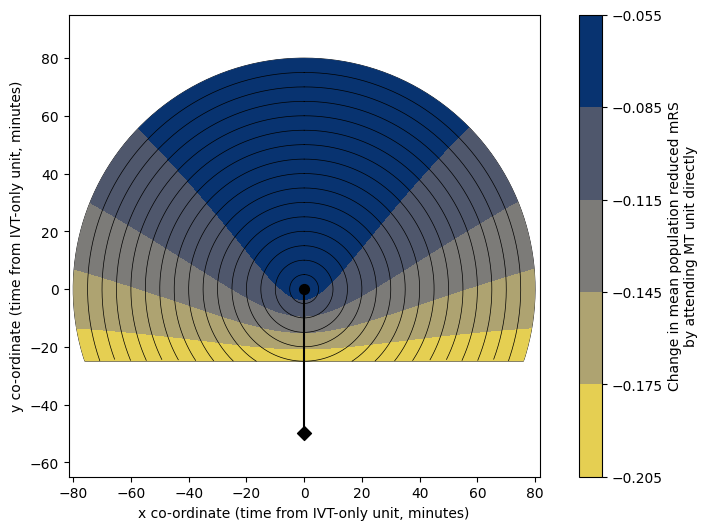

In [51]:
circle_plot(
    df_mixed_diff['mrs_shift'].values.reshape(grid_time_travel_directly_to_mt.shape),
    fixed_times['travel_ivt_to_mt'], 
    time_travel_max,
    time_step_circle,
    vmin_mRS,
    vmax_mRS,
    imshow=0, 
    cmap='cividis_r',
    extent=extent,
    cbar_label=('Change in mean population reduced mRS\n'+
               'by attending MT unit directly'),
    # cbar_format_str='{:3.2f}', 
    n_contour_steps=5,
    ivt_coords=ivt_coords,
    mt_coords=mt_coords
    )

# Combined circle plot

Share these colour limits between all figures:

In [71]:
vmin_time = 0 
vmax_time = 60
vmin_util = -0.0250 # -0.045
vmax_util = 0.0875 # 0.035
vmin_mRS = -0.4 # -0.250 
vmax_mRS = 0.2 # 0.175
vmin_good = -0.0300
vmax_good = 0.09

Make new colour maps that are based on a diverging colour map but have the zero (white) off-centre:

In [72]:
from geography_plot import make_new_cmap_diverging

cmap = 'bwr'

cmap_util = make_new_cmap_diverging(
    vmin_util, vmax_util, cmap_base=f'{cmap}_r', cmap_name=f'{cmap}_util')
cmap_mRS = make_new_cmap_diverging(
    vmin_mRS, vmax_mRS, cmap_base=f'{cmap}', cmap_name=f'{cmap}_mRS')
cmap_good = make_new_cmap_diverging(
    vmin_good, vmax_good, cmap_base=f'{cmap}_r', cmap_name=f'{cmap}_good')

# For the time colours, take only the red half of 'bwr':
from matplotlib import colors
colours_time = plt.get_cmap(cmap)(np.linspace(0.5, 1.0, 256))
cmap_time = colors.LinearSegmentedColormap.from_list(f'{cmap}_time', colours_time)

Define contour levels for plotting: 

In [73]:
from geography_plot import make_levels_with_zeroish

level_step_util = 0.0125 # 0.005
levels_util = make_levels_with_zeroish(
    level_step_util, vmax_util, zeroish=1e-3, vmin=vmin_util)

level_step_mRS = 0.1 # 0.025
levels_mRS = make_levels_with_zeroish(
    level_step_mRS, vmax_mRS, zeroish=4e-3, vmin=vmin_mRS)

level_step_good_outcome = 0.015 # 0.025
levels_good_outcome = make_levels_with_zeroish(
    level_step_good_outcome, vmax_good, zeroish=1e-3, vmin=vmin_good)

level_step_time = 10
levels_time = make_levels_with_zeroish(
    level_step_time, vmax_time, zeroish=0.001, vmin=vmin_time)

Gather the shared parameters above into dictionaries:

In [74]:
params_util = {
    'col': 'added_utility',
    'cmap': cmap_util,
    # 'cbar_label': 'Change in population added utility by attending MT unit directly',
    'cbar_label': 'Mean added utility\nby attending MT unit directly',
    'level_step': level_step_util,
    'levels': levels_util,
    'vmin': vmin_util,
    'vmax': vmax_util,
    'title': 'Change in mean utility',
}

In [75]:
params_mRS = {
    'col': 'mrs_shift',
    'cmap': cmap_mRS,
    # 'cbar_label': 'Change in mean population reduced mRS by attending MT unit directly',
    'cbar_label': 'Mean change in mRS improvement\nby attending MT unit directly',
    'level_step': level_step_mRS,
    'levels': levels_mRS,
    'vmin': vmin_mRS,
    'vmax': vmax_mRS,
    'title': 'Change in mean mRS',
}

In [76]:
params_good = {
    'col': 'mrs_less_equal_2',
    'cmap': cmap_good,
    # 'cbar_label': 'Change in proportion with mRS <=2',
    'cbar_label': 'Change in proportion with mRS <=2\nby attending MT unit directly',
    'level_step': level_step_good_outcome,
    'levels': levels_good_outcome,
    'vmin': vmin_good,
    'vmax': vmax_good,
    'title': 'Change in proportion with mRS <=2',
}

In [77]:
params_time = {
    'col': None,
    'cmap': cmap_time,
    'cbar_label': 'Extra travel time to MT unit\n(minutes)',
    # 'level_step': None,
    # 'levels': [],
    'level_step': level_step_time,
    'levels': levels_time,
    'vmin': vmin_time,
    'vmax': vmax_time,
    'title': 'Additional travel time to MT centre',
}

The following big cell makes the plots.

In [78]:
def outcome_circle_plots(
        grid_times_diff,
        df_diff,
        time_travel_ivt_to_mt,
        params_time,
        params_util,
        params_mRS,
        params_good,
        coords_valid,
        title='',
    ):

    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        2, 4, figsize=(15,4), 
        gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]}
    )
    params_time['ax'] = axs[0,0]
    params_time['ax_cbar'] = axs[1,0]
    params_util['ax'] = axs[0,1]
    params_util['ax_cbar'] = axs[1,1]
    params_mRS['ax'] = axs[0,2]
    params_mRS['ax_cbar'] = axs[1,2]
    params_good['ax'] = axs[0,3]
    params_good['ax_cbar'] = axs[1,3]

    for i, params in enumerate([params_time, params_util, params_mRS, params_good]):
        if params['col'] != None:
            grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
            print(f'{params["col"]} {np.min(grid[coords_valid]):7.4f} '+
                    f'{np.max(grid[coords_valid]):7.4f}')
        else:
            grid = grid_times_diff

        if params['level_step'] is None:
            params['cbar_ticks'] = None
        else:
            params['cbar_ticks'] = np.arange(
                params['vmin'], params['vmax'] + params['level_step'], params['level_step'])
        
        circle_plot(
            grid,
            time_travel_ivt_to_mt,
            time_travel_max,
            time_step_circle,
            params['vmin'],
            params['vmax'],
            ivt_coords=ivt_coords,
            mt_coords=mt_coords,
            extent=extent,
            imshow=0,
            ax=params['ax'],
            cax=params['ax_cbar'],
            cmap=params['cmap'],
            cbar_label=params['cbar_label'],
            cbar_orientation='horizontal',
            # cbar_format_str='{:3.2f}',
            levels=params['levels'],
            cbar_ticks=params['cbar_ticks']
        )

        if i == 0:
            # Draw legend now:
            fig.legend(loc='upper right', bbox_to_anchor=[0.9, 1.0], ncol=1, frameon=True)

        ax = params['ax']
        # ax.set_title(params['title'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_color('None')
        ax.set_ylim(-82,82)
        # Reduce font size of ax.xaxis.label
        ax.tick_params(axis='both', which='major', labelsize=9)

        # Rotate colourbar tick labels to prevent overlapping:
        for tick in params['ax_cbar'].get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(9)
            tick.set_horizontalalignment('center')

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    filename = (f'circle_plots_stroke_type_{title}_60_60')
    plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
    plt.show()

added_utility -0.0219  0.0000
mrs_shift  0.0000  0.1236
mrs_less_equal_2 -0.0239  0.0000


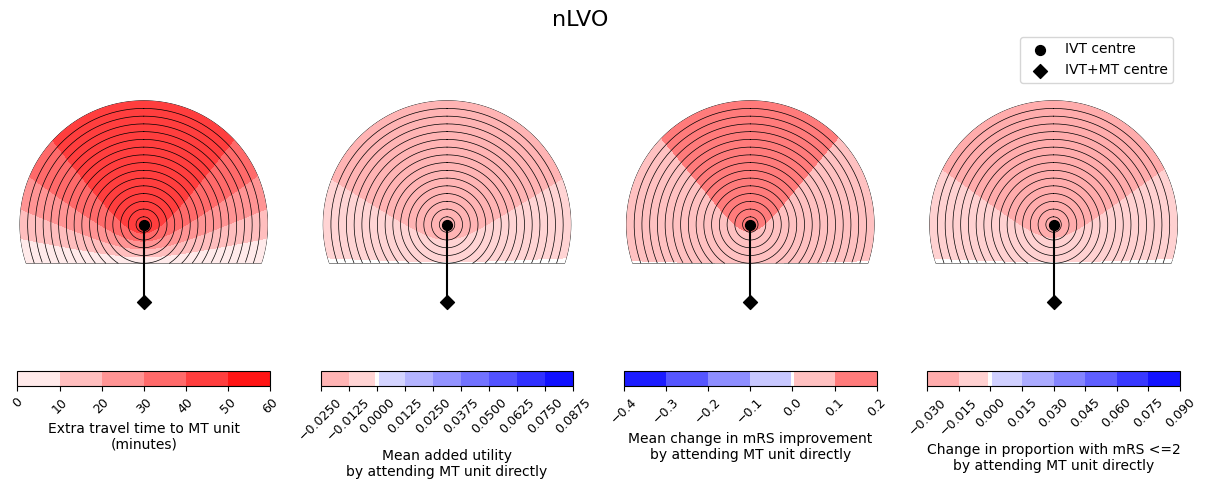

In [79]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_nlvo_ivt_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title='nLVO',
)

added_utility  0.0462  0.0758
mrs_shift -0.4013 -0.2391
mrs_less_equal_2  0.0480  0.0807


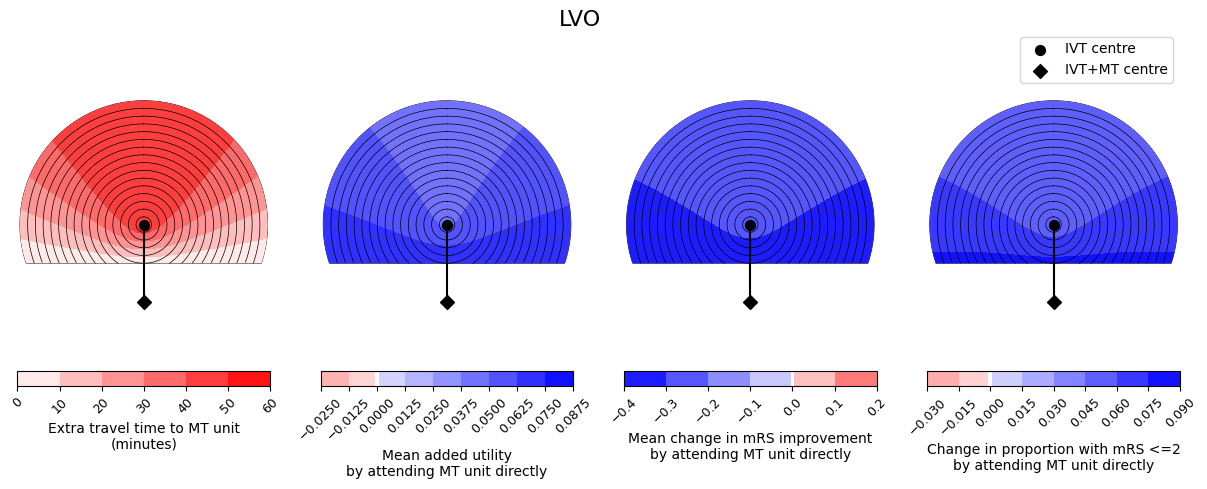

In [80]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_lvo_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title='LVO',
)

added_utility  0.0124  0.0382
mrs_shift -0.2023 -0.0593
mrs_less_equal_2  0.0124  0.0407


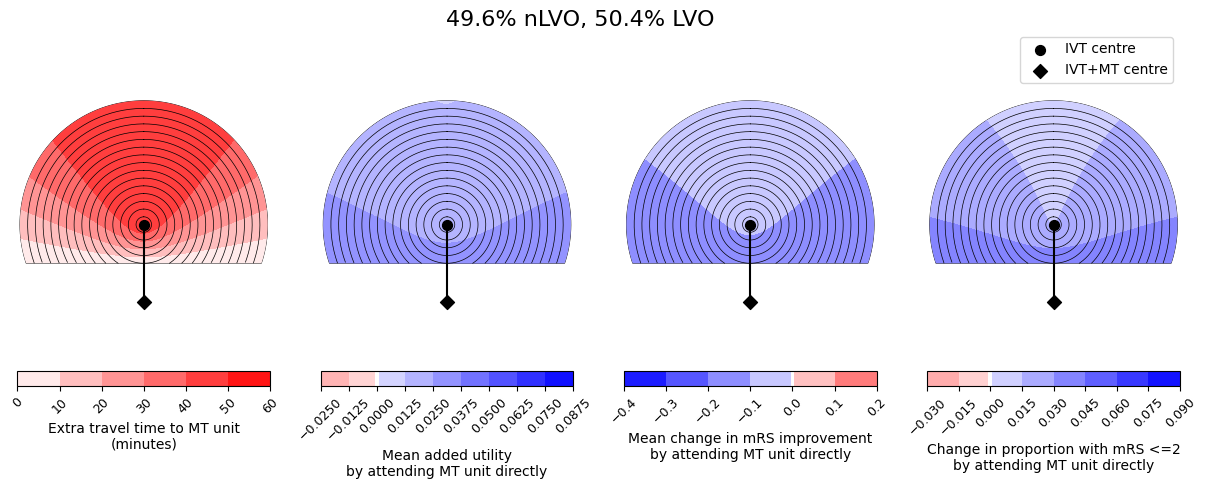

In [81]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_mixed_diff,
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    coords_valid,
    title=f'{prop_nlvo_of_treated:.1%} nLVO, {prop_lvo_of_treated:.1%} LVO',
)

## One big figure with all circle grids

In [82]:
def big_outcome_circle_plots(
        grid_times_diff,
        dfs,
        time_travel_ivt_to_mt,
        params_time,
        params_util,
        params_mRS,
        params_good,
        title='',
        row_titles=[],
        col_titles=[],
    ):
    if len(row_titles) == 0:
        row_titles = [''] * len(dfs)
    if len(col_titles) == 0:
        col_titles = [''] * 4
    

    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        4, 4, figsize=(12, 10), 
        gridspec_kw={'wspace': 0.2, 'hspace': 0.0, 'height_ratios': [20, 20, 20, 1]}
    )
    leg_drawn = False

    for d, df_diff in enumerate(dfs):
        params_time['ax'] = axs[d, 0]
        params_time['ax_cbar'] = axs[-1, 0]
        params_util['ax'] = axs[d, 1]
        params_util['ax_cbar'] = axs[-1, 1]
        params_mRS['ax'] = axs[d, 2]
        params_mRS['ax_cbar'] = axs[-1, 2]
        params_good['ax'] = axs[d, 3]
        params_good['ax_cbar'] = axs[-1, 3]
    
        for i, params in enumerate([params_time, params_util, params_mRS, params_good]):
            if params['col'] != None:
                grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
            else:
                grid = grid_times_diff

            if params['level_step'] is None:
                params['cbar_ticks'] = None
            else:
                params['cbar_ticks'] = np.arange(
                    params['vmin'], params['vmax'] + params['level_step'], params['level_step'])

            if ((params['col'] is None) & (d < (len(dfs) -1))):
                pass
            else:
                circle_plot(
                    grid,
                    time_travel_ivt_to_mt,
                    time_travel_max,
                    time_step_circle,
                    params['vmin'],
                    params['vmax'],
                    ivt_coords=ivt_coords,
                    mt_coords=mt_coords,
                    extent=extent,
                    imshow=0,
                    ax=params['ax'],
                    cax=params['ax_cbar'],
                    cmap=params['cmap'],
                    cbar_label=params['cbar_label'],
                    cbar_orientation='horizontal',
                    # cbar_format_str='{:3.2f}',
                    levels=params['levels'],
                    cbar_ticks=params['cbar_ticks']
                )
            
                if leg_drawn is False:
                    # Draw legend now:
                    fig.legend(loc='upper right', bbox_to_anchor=[0.9, 0.95], ncol=1, frameon=True)
                    leg_drawn = True
    
            ax = params['ax']
            # ax.set_title(params['title'])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'bottom', 'left', 'right']:
                ax.spines[spine].set_color('None')
            ax.set_ylim(-82,82)
            # Reduce font size of ax.xaxis.label
            ax.tick_params(axis='both', which='major', labelsize=9)

            # If there are too many colourbar tick labels, reduce them:
            if len(params['ax_cbar'].get_xticks()) > 8:
                xticks = params['ax_cbar'].get_xticks()[::2]
                params['ax_cbar'].set_xticks(xticks)
            # Rotate colourbar tick labels to prevent overlapping:
            for tick in params['ax_cbar'].get_xticklabels():
                tick.set_rotation(45)
                tick.set_fontsize(9)
                tick.set_horizontalalignment('right')  # 'center')

    for i, row_title in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i].set_xlabel(col_title, fontsize=14)
        axs[0, i].xaxis.set_label_position('top')

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    filename = (f'circle_plots_stroke_type_all_60_60')
    plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
    plt.show()

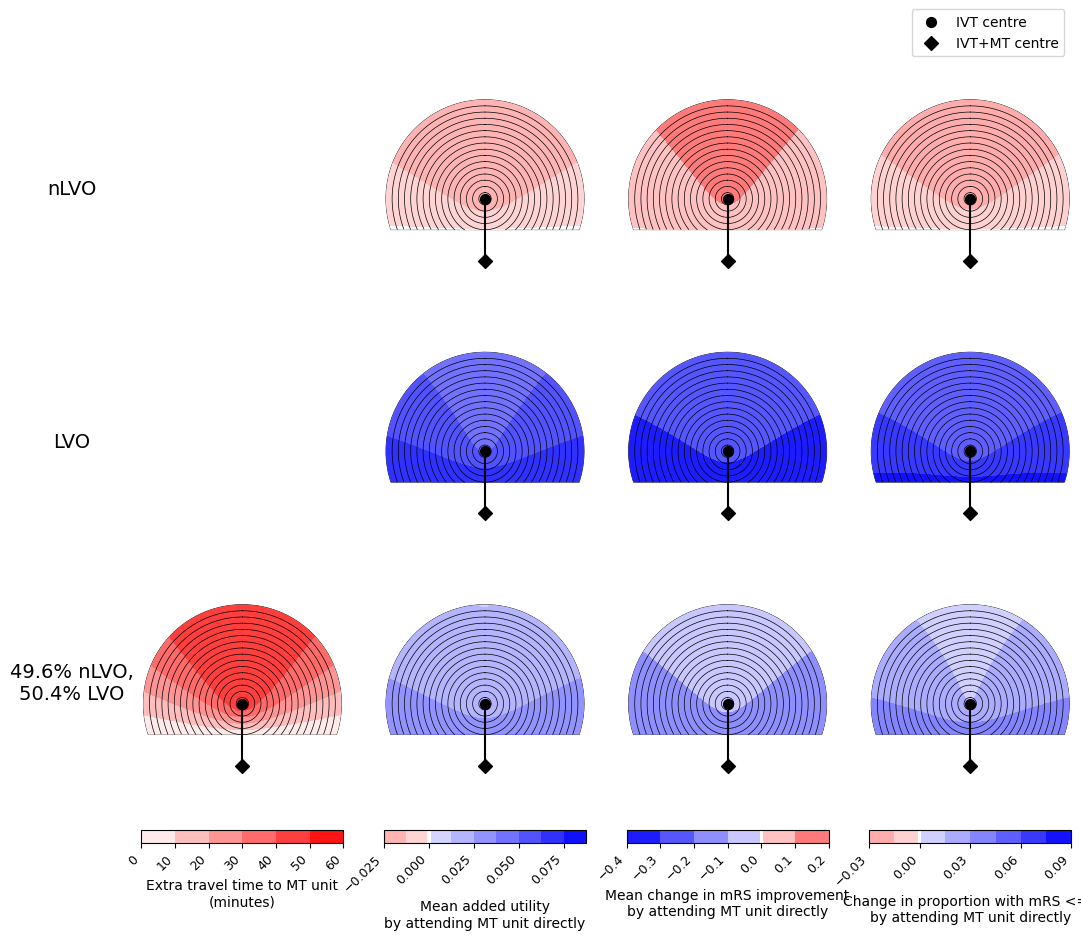

In [83]:
big_outcome_circle_plots(
    -grid_time_travel_directly_diff,
    [df_nlvo_ivt_diff, df_lvo_diff, df_mixed_diff],
    fixed_times['travel_ivt_to_mt'],
    params_time,
    params_util,
    params_mRS,
    params_good,
    row_titles=['nLVO', 'LVO', f'{prop_nlvo_of_treated:.1%} nLVO,\n{prop_lvo_of_treated:.1%} LVO'],
    col_titles=[],
)